In [62]:
import os
new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)

import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import yaml
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

In [63]:
def load_data_to_train(): 
    data_path = ('data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_LOG_IMPUTED_BY_CLASS_6PP.npy.gz')
    print('Loading from:\n', data_path)
    with gzip.open(data_path, 'rb') as f:
        np_data = np.load(f, allow_pickle=True)
    return np_data.item()['meta'], np_data.item()['lcs'], np_data

def plot_single_phased_lc(lc_real, cls='RR Lyrae', ID='EXAMPLE', period=1):
    """
    Creates a single light curve plot, phased over two cycles, with real data,
    starting from the phase of the maximum magnitude value.

    Parameters
    ----------
    lc_real : numpy array or DataFrame
        Real light curve data to be plotted.
    cls : string, optional
        Label to be displayed as legend.
    ID : string, optional
        Identifier for the plot, used in title and filename.
    period : float, optional
        Period of the light curve, used to calculate the phase.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(7, 4))

    # Identify the time of maximum magnitude
    max_mag_time = lc_real.loc[lc_real['magnitude'].idxmax(), 'time']

    # Calculate the phase, ensuring it starts from the maximum magnitude
    phased_time = ((lc_real['time'] - max_mag_time) / period) % 1
    lc_real['phased_time'] = phased_time

    # Sort by phased time for plotting continuity
    lc_real_sorted = lc_real.sort_values('phased_time')

    # Extend the phase and magnitude for two cycles
    phased_time_extended = np.concatenate([lc_real_sorted['phased_time'], 
                                           lc_real_sorted['phased_time'] + 1])
    
    magnitude_extended = np.concatenate([lc_real_sorted['magnitude'], 
                                         lc_real_sorted['magnitude']])
    
    ax.errorbar(phased_time_extended, magnitude_extended, fmt='.', c='gray', 
                alpha=0.5, label=cls)
    
    ax.set_xlabel('Phase', fontsize=15)
    ax.set_ylabel('Magnitude', fontsize=15)
    
    ax.invert_yaxis()
    ax.legend(loc='lower left')
    ax.set_title(ID)
    plt.tight_layout()

    plt.savefig(f'{ID}_lc_phased.png')  # Save the figure
    plt.show()

def plot_single_lc(lc_real, cls='RR Lyrae', ID='EXAMPLE', errorbar_color='blue'):
    """
    Creates a single light curve plot with real data, displaying photometric errors in a specified color.

    Parameters
    ----------
    lc_real : numpy array or DataFrame
        Real light curve data to be plotted. Expected to have 'time', 'magnitude', and 'magnitude_error' columns.
    cls : string, optional
        Label to be displayed as legend.
    ID : string, optional
        Identifier for the plot, used in title and filename.
    errorbar_color : string, optional
        Color for the error bars.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(7, 4))
    
    # Plotting the light curve with error bars in specified color
    ax.errorbar(lc_real['time'], lc_real['magnitude'], yerr=lc_real['error'],
                fmt='.', c='gray', ecolor=errorbar_color, alpha=0.5, label=cls)

    ax.set_xlabel('Time (MJD)', fontsize=15)  # Modified Julian Date for time axis
    ax.set_ylabel('Magnitude', fontsize=15)
    
    ax.invert_yaxis()  # Magnitude is usually plotted in reverse
    plt.title(ID)
    plt.tight_layout()

    plt.savefig(f'{ID}_lc.png')  # Save the figure before showing it
    plt.show()



In [64]:
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE = yaml.safe_load(file)

PATHS =YAML_FILE['paths']
PATH_LIGHT_CURVES_OGLE = PATHS['PATH_LIGHT_CURVES_OGLE']
PATH_FEATURES_TRAIN = PATHS['PATH_FEATURES_TRAIN']
PATH_FEATURES_TEST = PATHS['PATH_FEATURES_TEST']


lc_train = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')
new_cols = lc_train.ID.str.split("-", n = 3, expand = True)
new_cols.columns = ['survey', 'field', 'class', 'number']
lc_train = pd.concat([new_cols, lc_train], axis=1)


lc_test = pd.read_table(PATH_FEATURES_TEST, sep= ',')
new_cols = lc_test.ID.str.split("-", n = 3, expand = True)
new_cols.columns = ['survey', 'field', 'class', 'number']
lc_test = pd.concat([new_cols, lc_test], axis=1)


lc_train = pd.concat([lc_train, lc_test])


In [65]:
meta, lcs, np_data = load_data_to_train()

Loading from:
 data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_LOG_IMPUTED_BY_CLASS_6PP.npy.gz


In [66]:
static_synthetic_light_curves = pd.read_csv('/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/static_physical_parameters_to_sample.csv')
static_synthetic_light_curves.columns = ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
static_synthetic_light_curves.head()

ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements

In [ ]:
meta = meta[['OGLE_id', 'Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']]
meta.head()

,OGLE_id,Period,teff_val,[Fe/H]_J95,abs_Gmag,radius_val,logg
0,OGLE-LMC-ACEP-019,-0.041242,3.785559,-4.0969,5.1693,-0.123667,4.5263
1,OGLE-LMC-ACEP-019,-0.041242,3.785559,-4.0969,5.1693,-0.123667,4.5263
2,OGLE-LMC-ACEP-074,0.185606,3.774801,-1.9930,5.3787,-0.154220,4.5801
3,OGLE-LMC-ACEP-015,0.072205,3.776946,-2.5218,5.3769,-0.154530,4.5769
4,OGLE-LMC-ACEP-062,0.024934,3.766811,-3.6537,5.6399,-0.183427,4.6286


In [ ]:
# Columns to normalize and compare
columns_to_compare = ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']

# Normalize the columns in both DataFrames
scaler = MinMaxScaler()

# Normalize the columns in static_synthetic_light_curves
static_normalized = pd.DataFrame(scaler.fit_transform(static_synthetic_light_curves[columns_to_compare]),
                                 columns=columns_to_compare)

# Normalize the columns in meta
meta_normalized = pd.DataFrame(scaler.transform(meta[columns_to_compare]),
                               columns=columns_to_compare)

## Extract the star class from OGLE_id in meta
meta['class'] = meta['OGLE_id'].apply(lambda x: x.split('-')[2])

# Define the star classes and corresponding rows in static_synthetic_light_curves
star_classes = ['CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR']
class_row_ranges = {
    'CEP': range(0, 8),
    'DSCT': range(8, 16),
    'ECL': range(16, 24),
    'LPV': range(24, 32),
    'RRLYR': range(32, 40)
}

# Finding the closest row in meta for each row in static_synthetic_light_curves within the same class
closest_ids = []

for star_class in star_classes:
    # Filter meta and static_synthetic_light_curves for the current class
    meta_class = meta_normalized[meta['class'] == star_class]
    static_class_indices = class_row_ranges[star_class]
    static_class = static_normalized.iloc[static_class_indices]
    
    for i, row in static_class.iterrows():
        # Calculate the Euclidean distance from the current row to all rows in meta_class
        distances = distance.cdist([row.values], meta_class.values, metric='euclidean')
        
        # Find the index of the minimum distance
        closest_index = np.argmin(distances)
        
        # Get the corresponding OGLE_id from the meta DataFrame
        closest_id = meta.loc[meta['class'] == star_class].iloc[closest_index]['OGLE_id']
        closest_ids.append(closest_id)

# Add the closest OGLE_id as a new column in static_synthetic_light_curves
static_synthetic_light_curves['closest_OGLE_id'] = closest_ids

# Display the updated DataFrame
static_synthetic_light_curves.head()



,Period,teff_val,[Fe/H]_J95,abs_Gmag,radius_val,logg,closest_OGLE_id
0,1.833435,8.681266,-0.680311,1.582925,1.411982,3.388142,OGLE-SMC-CEP-1816
1,0.765400,8.685720,-1.161085,4.298409,0.168891,4.261909,OGLE-SMC-CEP-1816
2,0.352437,8.662407,-1.208199,5.379615,-0.316339,4.588407,OGLE-SMC-CEP-1816
3,1.234501,8.695780,-0.285252,2.392250,1.000636,3.674881,OGLE-SMC-CEP-1816
4,0.902811,8.713028,-0.341738,2.779474,0.767820,3.848722,OGLE-SMC-CEP-1816


In [ ]:
static_synthetic_light_curves

,Period,teff_val,[Fe/H]_J95,abs_Gmag,radius_val,logg,closest_OGLE_id
0,1.833435,8.681266,-0.680311,1.582925,1.411982,3.388142,OGLE-SMC-CEP-1816
1,0.765400,8.685720,-1.161085,4.298409,0.168891,4.261909,OGLE-SMC-CEP-1816
2,0.352437,8.662407,-1.208199,5.379615,-0.316339,4.588407,OGLE-SMC-CEP-1816
3,1.234501,8.695780,-0.285252,2.392250,1.000636,3.674881,OGLE-SMC-CEP-1816
4,0.902811,8.713028,-0.341738,2.779474,0.767820,3.848722,OGLE-SMC-CEP-1816
5,0.491883,8.666631,-0.460400,4.380239,0.155720,4.272116,OGLE-SMC-CEP-1816
6,1.333817,8.715938,-0.990120,3.118951,0.641498,3.807208,OGLE-SMC-CEP-1816
7,0.571347,8.602060,-3.652078,5.412083,-0.162684,4.467825,OGLE-SMC-CEP-1816
8,-2.665790,8.975534,-2.570547,3.578616,-0.043018,4.415237,OGLE-GD-DSCT-0042
9,-2.222997,9.059220,-0.604562,1.734851,0.621988,4.126462,OGLE-GD-DSCT-0042


In [ ]:
static_synthetic_light_curves.to_csv('/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/static_physical_parameters_to_sample.csv', index=False)

In [ ]:
static_synthetic_light_curves.head(40)

,Period,teff_val,[Fe/H]_J95,abs_Gmag,radius_val,logg,closest_OGLE_id
0,1.833435,8.681266,-0.680311,1.582925,1.411982,3.388142,OGLE-SMC-CEP-1816
1,0.765400,8.685720,-1.161085,4.298409,0.168891,4.261909,OGLE-SMC-CEP-1816
2,0.352437,8.662407,-1.208199,5.379615,-0.316339,4.588407,OGLE-SMC-CEP-1816
3,1.234501,8.695780,-0.285252,2.392250,1.000636,3.674881,OGLE-SMC-CEP-1816
4,0.902811,8.713028,-0.341738,2.779474,0.767820,3.848722,OGLE-SMC-CEP-1816
5,0.491883,8.666631,-0.460400,4.380239,0.155720,4.272116,OGLE-SMC-CEP-1816
6,1.333817,8.715938,-0.990120,3.118951,0.641498,3.807208,OGLE-SMC-CEP-1816
7,0.571347,8.602060,-3.652078,5.412083,-0.162684,4.467825,OGLE-SMC-CEP-1816
8,-2.665790,8.975534,-2.570547,3.578616,-0.043018,4.415237,OGLE-GD-DSCT-0042
9,-2.222997,9.059220,-0.604562,1.734851,0.621988,4.126462,OGLE-GD-DSCT-0042


| Type  | P (days) | T<sub>eff</sub> (K) | [Fe/H] (dex) | Abs. mag. (g band) | r (R<sub>⊙</sub>) | log g (dex) |
|-------|----------|---------------------|--------------|--------------------|------------------|-------------|
| CEP   | 3.78     | 5,553               | -0.95        | 2.94               | 2.34             | 3.69        |
| DCST  | 0.07     | 6,002               | -3.61        | 6.07               | 0.50             | 4.82        |
| ECL   | 1.42     | 4,769               | -1.79        | 6.76               | 0.58             | 4.60        |
| LPV   | 308.96   | 3,827               | 0.12         | -2.38              | 100.48           | 0.67        |
| RRLYR | 0.45     | 5,431               | -1.67        | 5.80               | 0.73             | 4.50        |


In [ ]:
meta[(meta.Type=='CEP') &  (meta.Period > np.log10(3.7)) & (meta.Period < np.log10(3.8)) 
        & (meta.teff_val < np.log10(5800)) & (meta.teff_val > np.log10(5300)) 
        & (meta.abs_Gmag < 3) & (meta.abs_Gmag > 2.9)
        & (meta.logg < 3.8) & (meta.logg > 3.5)
        ]
        

AttributeError: 'DataFrame' object has no attribute 'Type'

In [ ]:
meta[(meta.Type=='CEP') &  (meta.Period > np.log10(3.7)) & (meta.Period < np.log10(3.8)) 
        & (meta.teff_val < np.log10(5800)) & (meta.teff_val > np.log10(5300)) 
        & (meta.abs_Gmag < 4) & (meta.abs_Gmag > 2)]
        
lc_i = meta[meta.OGLE_id=='OGLE-LMC-CEP-0316']

print('Period: ', np.power(10, lc_i.Period.values[0]))
print('teff_val: ', np.power(10, lc_i.teff_val.values[0]))
print('radius_val: ', np.power(10, lc_i.radius_val.values[0]))
lc_i


Period:  3.7351777999999998
teff_val:  5551.746000000001
radius_val:  2.4244999999999997


,OGLE_id,Type,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
7388,OGLE-LMC-CEP-0316,CEP,-0.6031,3.74443,0.572311,2.9532,0.384622,3.6729


Int64Index([7388], dtype='int64')


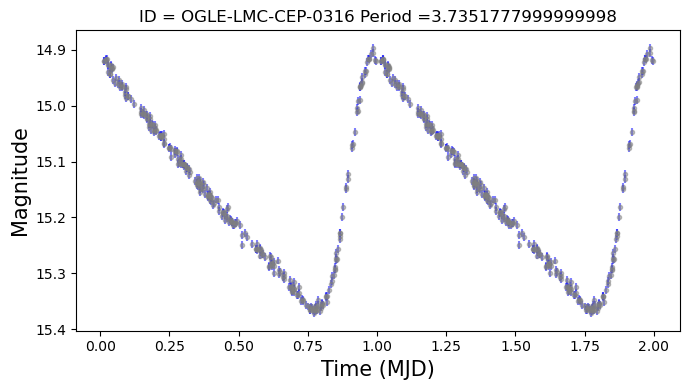

In [ ]:


lc, lc_id_to_title = ('OGLE-LMC-CEP-0316.dat', 'OGLE-LMC-CEP-0316')
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='CEP', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [ ]:
np.log10(3400)


3.531478917042255

Int64Index([50113], dtype='int64')


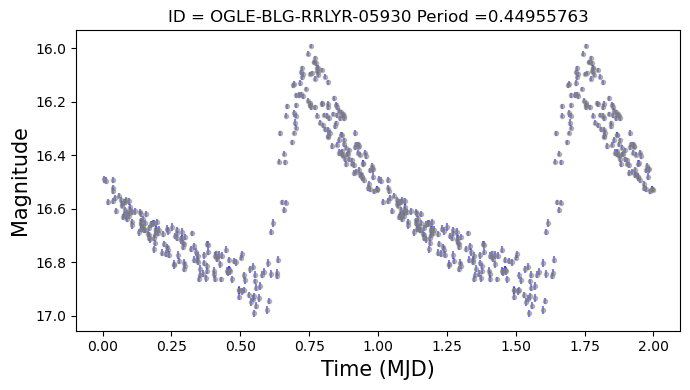

In [ ]:
lc, lc_id_to_title = ('OGLE-BLG-RRLYR-05930.dat', 'OGLE-BLG-RRLYR-05930')
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='CEP', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [ ]:
meta[(meta.Type=='LPV')].radius_val.max()

2.879933826910855

/home/franciscoperez/anaconda3/envs/cnnpelsvae/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


Int64Index([45706], dtype='int64')
(600, 3)


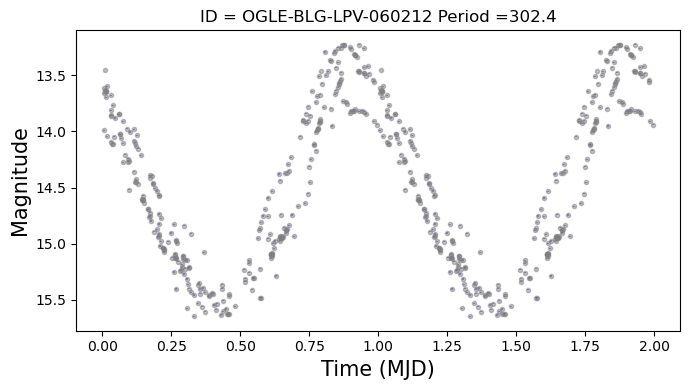

In [ ]:
meta[(meta.Type=='LPV') &  (meta.Period > np.log10(300)) & (meta.Period < np.log10(340)) 
        & (meta['[Fe/H]_J95'] < 1) & (meta['[Fe/H]_J95'] > -.5)
        & (meta.teff_val < np.log10(4000)) & (meta.teff_val > np.log10(3500)) 
        & (meta.abs_Gmag < -2) & (meta.abs_Gmag > -3)
        & (meta.radius_val < np.log10(120)) & (meta.teff_val > np.log10(80)) 
         & (meta.logg < 0.7) & (meta.logg > 0.65)]

lc, lc_id_to_title = ('OGLE-BLG-LPV-060212.dat', 'OGLE-BLG-LPV-060212')
meta[meta.OGLE_id==lc_id_to_title].drop_duplicates(subset=['OGLE_id'], inplace=True)
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

print(lcu.shape)
p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='LPV', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [ ]:
meta[(meta.Type=='ECL') &  (meta.Period > np.log10(1.2)) & (meta.Period < np.log10(1.6))
        & (meta.teff_val < np.log10(5000)) & (meta.teff_val > np.log10(4600)) 
        & (meta.abs_Gmag < 7) & (meta.abs_Gmag > 6.4)
        & (meta.radius_val < np.log10(0.7)) & (meta.teff_val > np.log10(0.4)) 
         & (meta.logg < 5.0) & (meta.logg > 4.4) 
         & (meta['[Fe/H]_J95'] < -1.5) & (meta['[Fe/H]_J95'] > -2)]

,OGLE_id,Type,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
23308,OGLE-BLG-ECL-245076,ECL,-1.5792,3.698268,0.198867,6.8713,-0.293282,4.7717


/home/franciscoperez/anaconda3/envs/cnnpelsvae/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


Int64Index([23308], dtype='int64')
(600, 3)


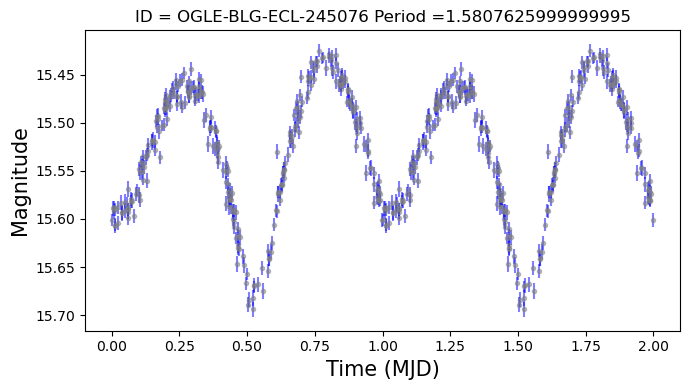

In [ ]:
meta[(meta.Type=='ECL') &  (meta.Period > np.log10(1.2)) & (meta.Period < np.log10(1.6))
        & (meta.teff_val < np.log10(5000)) & (meta.teff_val > np.log10(4600)) 
        & (meta.abs_Gmag < 7) & (meta.abs_Gmag > 6.4)
        & (meta.radius_val < np.log10(0.7)) & (meta.teff_val > np.log10(0.4)) 
        & (meta.logg < 5.0) & (meta.logg > 4.4) 
        & (meta['[Fe/H]_J95'] < -1.5) & (meta['[Fe/H]_J95'] > -2)]


lc, lc_id_to_title = ('OGLE-BLG-ECL-245076.dat', 'OGLE-BLG-ECL-245076')
meta[meta.OGLE_id==lc_id_to_title].drop_duplicates(subset=['OGLE_id'], inplace=True)
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

print(lcu.shape)
p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='LPV', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [ ]:
meta[(meta.Type=='DSCT') &  (meta.Period > np.log10(0.07)) & (meta.Period < np.log10(1))
        & (meta.teff_val < np.log10(8000)) & (meta.teff_val > np.log10(5000))  
        & (meta['[Fe/H]_J95'] < -1.5) & (meta['[Fe/H]_J95'] > -5)        
        ].drop_duplicates()

,OGLE_id,Type,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
14796,OGLE-GD-DSCT-0022,DSCT,-3.1688,3.783063,-0.956404,5.4374,-0.178552,4.6720
14797,OGLE-GD-DSCT-0032,DSCT,-3.4426,3.746492,-1.082435,5.9138,-0.201142,4.6510
14812,OGLE-GD-DSCT-0057,DSCT,-2.5766,3.827043,-0.892319,3.3031,0.158242,4.0327
14836,OGLE-LMC-DSCT-2346,DSCT,-1.5948,3.699927,-0.956781,6.8767,-0.298518,4.7778
14881,OGLE-GD-DSCT-0055,DSCT,-3.0746,3.786364,-1.075830,5.1756,-0.132768,4.5571


                 OGLE_id  Type  [Fe/H]_J95  teff_val    Period  abs_Gmag  \
14796  OGLE-GD-DSCT-0022  DSCT     -3.1688  3.783063 -0.956404    5.4374   
14797  OGLE-GD-DSCT-0032  DSCT     -3.4426  3.746492 -1.082435    5.9138   

       radius_val   logg  
14796   -0.178552  4.672  
14797   -0.201142  4.651  
Int64Index([14796, 14802, 14819, 14822, 14826, 14960, 14963, 14992, 15002,
            15055,
            ...
            19128, 19130, 19223, 19240, 19425, 19475, 19490, 19516, 19642,
            19684],
           dtype='int64', length=113)
(67800, 3)


/home/franciscoperez/anaconda3/envs/cnnpelsvae/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


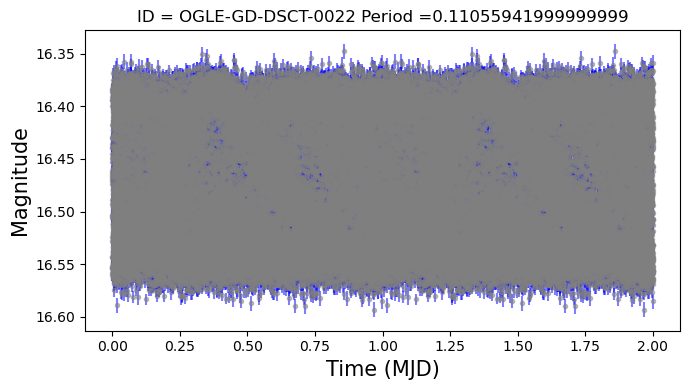

In [ ]:
print(meta[(meta.Type=='DSCT') &  (meta.Period > np.log10(0.07)) & (meta.Period < np.log10(0.5))
        & (meta.teff_val < np.log10(6500)) & (meta.teff_val > np.log10(5500)) 
        & (meta['[Fe/H]_J95'] < -2.5) & (meta['[Fe/H]_J95'] > -4)        
        & (meta.abs_Gmag < 7) & (meta.abs_Gmag > 5)
        & (meta.radius_val < np.log10(0.7)) & (meta.teff_val > np.log10(0.4)) 
         & (meta.logg < 5.0) & (meta.logg > 4.6) ].drop_duplicates())


lc, lc_id_to_title = ('OGLE-GD-DSCT-0022.dat', 'OGLE-GD-DSCT-0022')
meta[meta.OGLE_id==lc_id_to_title].drop_duplicates(subset=['OGLE_id'], inplace=True)
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

print(lcu.shape)
p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='LPV', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [ ]:
lc_train[(lc_train['class']=='DSCT') & (lc_train['PeriodLS']<0.8) & (lc_train['PeriodLS']>0.6)].ID

1472      OGLE-LMC-DSCT-1737.dat
1668      OGLE-LMC-DSCT-1605.dat
2571      OGLE-LMC-DSCT-1066.dat
2747      OGLE-LMC-DSCT-0943.dat
3685      OGLE-LMC-DSCT-1004.dat
5780      OGLE-LMC-DSCT-1851.dat
6653      OGLE-LMC-DSCT-2426.dat
9445      OGLE-LMC-DSCT-0965.dat
12412     OGLE-LMC-DSCT-0913.dat
12602     OGLE-LMC-DSCT-2425.dat
17178     OGLE-LMC-DSCT-1537.dat
18232     OGLE-LMC-DSCT-0613.dat
24468     OGLE-LMC-DSCT-1064.dat
42081     OGLE-LMC-DSCT-0547.dat
44205     OGLE-LMC-DSCT-1042.dat
88163     OGLE-LMC-DSCT-1736.dat
158227    OGLE-LMC-DSCT-0464.dat
169447    OGLE-LMC-DSCT-0003.dat
186978    OGLE-LMC-DSCT-0401.dat
245985    OGLE-LMC-DSCT-1990.dat
276987    OGLE-LMC-DSCT-0540.dat
284434    OGLE-LMC-DSCT-0771.dat
295475    OGLE-LMC-DSCT-1885.dat
322146    OGLE-LMC-DSCT-0501.dat
359826    OGLE-LMC-DSCT-0189.dat
369205    OGLE-LMC-DSCT-0122.dat
375634    OGLE-LMC-DSCT-0818.dat
466       OGLE-LMC-DSCT-2703.dat
1169      OGLE-LMC-DSCT-0210.dat
1273      OGLE-LMC-DSCT-2648.dat
1908      